# **Service Change Data Processer**
___

# Notebook contents
1. Uploading calendar *(requires calendar.csv)*
1. Determining service day counts
1. Uploading shake data
    1. Raw shake data across separate Excel sheets *(requires raw_shake_data.xlsx)*
    1. Raw shake data as CSV *(requires raw_shake_data.csv)*
1. Constructing master dataframe
1. Deriving summary tables
1. Downloading dataframes

___
# 1. Uploading calendar

The calendar should be prepared in the directory folder as "calendar.csv". It should contain the following headers:
* **fy:** Fiscal year, formatted as FY####
* **date:** Date, formatted as MM/DD/YYYY
* **shake:** Shake, formatted as YYYY-Month-Shake
* **month:** Month, abbreviated with the first 3 letters (e.g., Jan, Feb, Mar, etc.)
* **day:** Day of the week, abbreviated with the first 3 letters (e.g., Mon, Tue, Wed, etc.)
* **holiday:** Whether or not the day is a holiday, given as Reg, Sun, or No
* **svc:** Service configuration provided on the day, given as Mtt, Wed, Fri, Sat, or Sun
* **schoolday:** Whether or not the day is a schoolday, given as Yes or No

#### See an example of a properly formatted calendar.csv file [here](https://culvercity-my.sharepoint.com/:x:/g/personal/diana_chang_culvercity_org/EXuwWoR6rKhHokDhZeQDds0BWyqtdugImKogcAKO9QAEqA?e=yoyG0R).

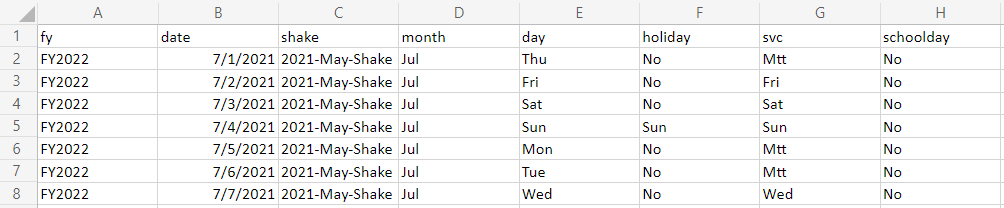

In [96]:
# Import packages
import numpy as np
import pandas as pd
import itertools
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [97]:
# Upload raw calendar
calendar = pd.read_csv('calendar.csv')

# Preview calendar
calendar.head()

,fy,date,shake,month,day,holiday,svc,schoolday
0,FY2022,7/1/2021,2021-May-Shake,Jul,Thu,No,Mtt,No
1,FY2022,7/2/2021,2021-May-Shake,Jul,Fri,No,Fri,No
2,FY2022,7/3/2021,2021-May-Shake,Jul,Sat,No,Sat,No
3,FY2022,7/4/2021,2021-May-Shake,Jul,Sun,Sun,Sun,No
4,FY2022,7/5/2021,2021-May-Shake,Jul,Mon,No,Mtt,No


___
# 2. Determining service day counts

This section uses the calendar dataframe in order to derive two other dataframes:
* **service_days_by_shake_fy_month:** Reports the number of service days and schooldays during each applicable combination of <u>shake</u>, <u>fiscal year</u>, and <u>month</u>.
  * e.g., <u>2021-May-Shake</u> in <u>August</u> of <u>FY2022</u> contained 31 service days, 9 of which were schooldays
* **service_days_by_shake_fy_month_svc:** Reports the number of service days and schooldays during each applicable combination of <u>shake</u>, <u>fiscal year</u>, <u>month</u>, and <u>service configuration</u>.
  * e.g., <u>2021-May-Shake</u> in <u>August</u> of <u>FY2022</u> contained 14 <u>Monday-Tuesday-Thursday</u> service days, 6 of which were schooldays

In [98]:
# Create "combo" function to group calendar dataframe by combinations of parameters
def combo(df, index_cols, agg_dict, rename_dict):
    temp = pd.DataFrame(df.groupby(index_cols).agg(agg_dict))
    temp = temp.rename(columns=rename_dict)
    return temp

# Create dataframe reporting number of days and schooldays in each unique shake-fy-month combination
service_days_by_shake_fy_month = combo(calendar,
                                    ['shake','fy','month'],
                                    {'month':'size','schoolday':lambda x: (x == 'Yes').sum()},
                                    {'month':'days','schoolday':'schooldays'})

# Create dataframe reporting number of days and schooldays in each unique shake-fy-month-service combination
service_days_by_shake_fy_month_svc = combo(calendar,
                                        ['shake','fy','month','svc'],
                                        {'svc':'size','schoolday':lambda x: (x == 'Yes').sum()},
                                        {'svc':'days','schoolday':'schooldays'})

In [99]:
# Preview service days by shake-month
service_days_by_shake_fy_month.head()

days  schooldays
shake          fy     month                  
2021-May-Shake FY2022 Aug      31           9
                      Jul      31           0
                      Sep      12           7
2021-Sep-Shake FY2022 Dec      31          13
                      Jan       3           1

In [100]:
# Preview service days by shake-month-service
service_days_by_shake_fy_month_svc.head()

days  schooldays
shake          fy     month svc                  
2021-May-Shake FY2022 Aug   Fri     4           2
                            Mtt    14           6
                            Sat     4           0
                            Sun     5           0
                            Wed     4           1

___
# 3. Uploading shake data

Run *either section 3a or 3b* depending on the format in which the raw shake data is available. See subsections for details on formatting.
* **3a:** This option assumes that the raw data is close to the form in which the data providers sent it.
  * It is contained in an Excel workbook with a separate sheet for each service configuration.
  * Time data is in HH:MM:SS format.
  * Shake and service columns do not exist.
  * The workbook only contains data for a single shake.
* **3b:** This option assumes that the raw data has already been manually reformatted to an extent.
  * It is contained in a CSV file.
  * Time data is in decimal format.
  * Shake and service columns exist.
  * There may be data from multiple shakes.

___
## 3a. Raw shake data across separate Excel sheets

For this option, the raw shake data should be prepared in the directory folder as "raw_shake_data.xlsx". It should contain 5 separate sheets, one for each service configuration (Mtt, Wed, Fri, Sat, and Sun). Each sheet should contain a table formatted as such:

* Cell A1 should contain the service configuration (Mtt, Wed, Fri, Sat, or Sun).
* Cell B1 should contain the shake name (YYYY-Month-Shake).
* Row 2 should contain the following 8 headers:
  * **route:** Route, given as 1, 1C, 2, 3, 4, 5, 5C1, 5C2, 6, 6R, or 7
  * **trips_rev:** Number of revenue trips
  * **hrs_rev_svc:** In-service time (revenue), formatted as HH:MM:SS (Make sure Excel has not added anything extra to these cells)
  * **mileage_rev:** Revenue distance in miles
  * **hrs_nonrev_dh:** Deadhead time (non-revenue), formatted as HH:MM:SS
  * **mileage_nonrev_dh:** Deadhead distance in miles
  * **hrs_rev_layover:** Layover time (revenue), formatted as HH:MM:SS
  * **hrs_nonrev_pull:** Pull time (non-revenue), formatted as HH:MM:SS

#### See an example of a properly formatted raw_shake_data.xlsx file [here](https://culvercity-my.sharepoint.com/:x:/g/personal/diana_chang_culvercity_org/EeVMU9Q_M_ZEsQC4gKeIRhYBAzgyVg5tvN2gR6ekjO1aZA?e=25h1u6).

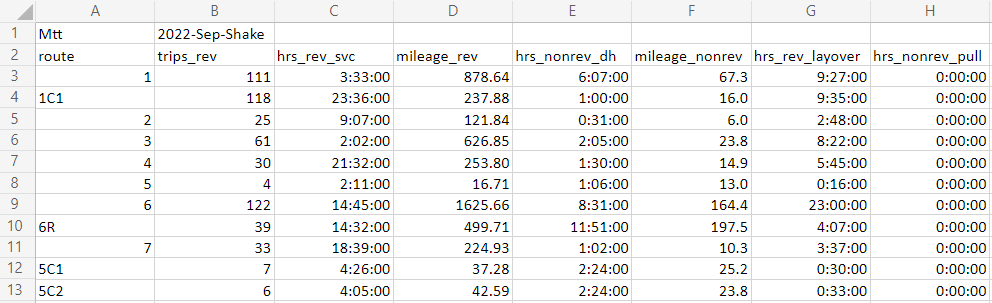

In [123]:
# Upload raw shake data
raw_shake_data = pd.read_excel('raw_shake_data.xlsx', sheet_name=None)

# Create separate dataframe for each service configuration (Mtt, Wed, etc.)
def sheet_to_df(df):
    svc = df.columns[0]
    shake = df.columns[1]
    df.columns = df.loc[0]
    df = df.drop(0)
    df['svc'] = svc
    df['shake'] = shake
    for col in ['mileage_rev','mileage_nonrev']:
        df[col] = df[col].astype(np.float64)
    return df
shake_data_by_svc = {}
for svc in raw_shake_data.keys():
    shake_data_by_svc[svc] = sheet_to_df(raw_shake_data[svc])

# Convert all HH:MM:SS cells to hours in decimal form
def decimal_time(time):
    hours, minutes, seconds = map(int, time.split(':'))
    decimal_hours = hours + minutes/60 + seconds/3600
    return decimal_hours
hr_cols = ['hrs_rev_svc', 'hrs_rev_layover', 'hrs_nonrev_dh', 'hrs_nonrev_pull']
for svc in shake_data_by_svc.keys():
    for col in hr_cols:
        shake_data_by_svc[svc][col] = [decimal_time(time) for time in shake_data_by_svc[svc][col].astype(str)]

# Stack the separate dataframes together into one
shake_data = pd.concat(shake_data_by_svc.values(), axis=0).reset_index(drop=True)

# Preview shake data
shake_data.head()

,route,trips_rev,hrs_rev_svc,mileage_rev,hrs_nonrev_dh,mileage_nonrev,hrs_rev_layover,hrs_nonrev_pull,svc,shake
0,1,111,3.550,878.636,6.117,67.300,9.450,0.000,Mtt,2022-Sep-Shake
1,1C1,118,23.600,237.883,1.000,16.000,9.583,0.000,Mtt,2022-Sep-Shake
2,2,25,9.117,121.844,0.517,6.000,2.800,0.000,Mtt,2022-Sep-Shake
3,3,61,2.033,626.852,2.083,23.800,8.367,0.000,Mtt,2022-Sep-Shake
4,4,30,21.533,253.795,1.500,14.900,5.750,0.000,Mtt,2022-Sep-Shake


___
## 3b. Raw shake data as CSV

For this option, the raw shake data should be prepared in the directory folder as "raw_shake_data.csv". It should contain the following 10 headers:

* **shake:** Shake, formatted as YYYY-Month-Shake
* **svc:** Service configuration, given as Mtt, Wed, Fri, Sat, or Sun
* **route:** Route, given as 1, 1C, 2, 3, 4, 5, 5C1, 5C2, 6, 6R, or 7
* **trips_rev:** Number of revenue trips
* **hrs_rev_svc:** In-service time (revenue), formatted as decimal
* **mileage_rev:** Revenue distance in miles
* **hrs_nonrev_dh:** Deadhead time (non-revenue), formatted as decimal
* **mileage_nonrev_dh:** Deadhead distance in miles
* **hrs_rev_layover:** Layover time (revenue), formatted as decimal
* **hrs_nonrev_pull:** Pull time (non-revenue), formatted as decimal

#### See an example of a properly formatted raw_shake_data.csv file [here](https://culvercity-my.sharepoint.com/:x:/g/personal/diana_chang_culvercity_org/EbA1swVq9IRBvB-y7sdEzW4B_AvuwvIc2yP1Gw6OUMShlA?e=eJiPQD).

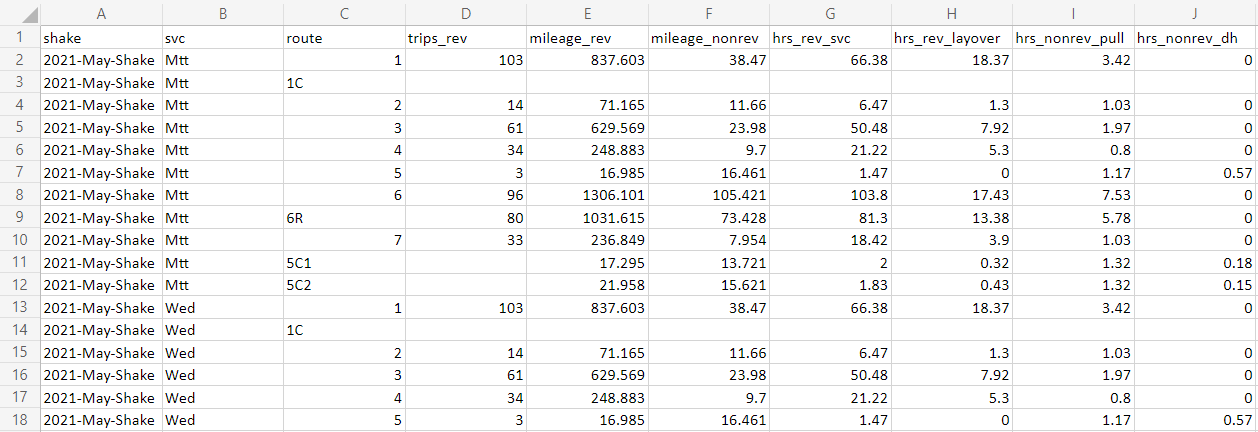

In [102]:
# Upload raw shake data
shake_data = pd.read_csv('raw_shake_data.csv')

# Preview shake data
shake_data.head()

,shake,svc,route,trips_rev,mileage_rev,mileage_nonrev,hrs_rev_svc,hrs_rev_layover,hrs_nonrev_pull,hrs_nonrev_dh
0,2021-May-Shake,Mtt,1,103.000,837.603,38.470,66.380,18.370,3.420,0.000
1,2021-May-Shake,Mtt,1C,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-May-Shake,Mtt,2,14.000,71.165,11.660,6.470,1.300,1.030,0.000
3,2021-May-Shake,Mtt,3,61.000,629.569,23.980,50.480,7.920,1.970,0.000
4,2021-May-Shake,Mtt,4,34.000,248.883,9.700,21.220,5.300,0.800,0.000


___
# 4. Constructing master dataframe

This section uses the raw shake data and service day counts to construct a master dataframe that contains a row for every applicable combination of shake, fiscal year, month, service, and route.

In [124]:
# Create nested indices in shake data dataframe by shake, service configuration, and route
shake_data = pd.DataFrame(shake_data.groupby(['shake','svc','route']).sum())

# Use hour and mileage columns to calculate new columns in shake data
shake_data['hrs_rev'] = shake_data['hrs_rev_svc'] + shake_data['hrs_rev_layover']
shake_data['hrs_nonrev'] = shake_data['hrs_nonrev_pull'] + shake_data['hrs_nonrev_dh']
shake_data['hrs'] = shake_data['hrs_rev'] + shake_data['hrs_nonrev']
shake_data['mileage'] = shake_data['mileage_rev'] + shake_data['mileage_nonrev']

# Preview shake data
shake_data.head(n=22)

0                         hrs_rev_svc  mileage_rev  hrs_nonrev_dh  \
shake          svc route                                            
2022-Sep-Shake Fri 1            3.550      878.636          6.117   
                   2            9.117      121.844          0.517   
                   3            2.033      626.852          2.083   
                   4           21.533      253.795          1.500   
                   5            2.183       16.705          1.100   
                   6           14.750     1625.656          8.517   
                   7           18.650      224.929          1.033   
                   1C1         23.600      237.883          1.000   
                   5C1          4.433       37.278          2.400   
                   5C2          4.083       42.587          2.400   
                   6R          14.533      499.705         11.850   
               Mtt 1            3.550      878.636          6.117   
                   2            9.117      121.844          0.517   
                   3            2.033      626.852          2.083   
                   4           21.533      253.795          1.500   
                   5            2.183       16.705          1.100   
                   6           14.750     1625.656          8.517   
                   7           18.650      224.929          1.033   
                   1C1         23.600      237.883          1.000   
                   5C1          4.433       37.278          2.400   
                   5C2          4.083       42.587          2.400   
                   6R          14.533      499.705         11.850   

0                         mileage_nonrev  hrs_rev_layover  hrs_nonrev_pull  \
shake          svc route                                                     
2022-Sep-Shake Fri 1              67.300            9.450            0.000   
                   2               6.000            2.800            0.000   
                   3              23.800            8.367            0.000   
                   4              14.900            5.750            0.000   
                   5              13.000            0.267            0.000   
                   6             164.400           23.000            0.000   
                   7              10.300            3.617            0.000   
                   1C1            16.000            9.583            0.000   
                   5C1            25.200            0.500            0.000   
                   5C2            23.800            0.550            0.000   
                   6R            197.500            4.117            0.000   
               Mtt 1              67.300            9.450            0.000   
                   2               6.000            2.800            0.000   
                   3              23.800            8.367            0.000   
                   4              14.900            5.750            0.000   
                   5              13.000            0.267            0.000   
                   6             164.400           23.000            0.000   
                   7              10.300            3.617            0.000   
                   1C1            16.000            9.583            0.000   
                   5C1            25.200            0.500            0.000   
                   5C2            23.800            0.550            0.000   
                   6R            197.500            4.117            0.000   

0                         hrs_rev  hrs_nonrev    hrs  mileage  
shake          svc route                                       
2022-Sep-Shake Fri 1       13.000       6.117 19.117  945.936  
                   2       11.917       0.517 12.433  127.844  
                   3       10.400       2.083 12.483  650.652  
                   4       27.283       1.500 28.783  268.695  
                   5        2.450       1.100  3.550   29.705  
                   6  

In [104]:
# Find all applicable combinations of shake, fy, month, service, and route
## List of unique shakes
shakes = list(set(shake_data.index.get_level_values('shake')))

## List of fiscal years applicable for each shake
shake_fys = dict.fromkeys(shakes)
for shake in shakes:
    mask = (calendar['shake'] == shake)
    temp = calendar[mask]
    shake_fys[shake] = list(set(temp['fy']))

## List of months applicable for each fiscal year applicable for each shake
shake_fy_months = {}
for shake in shakes:
    shake_fy_months[shake] = {}
    for fy in shake_fys[shake]:
        mask = (calendar['shake'] == shake) & (calendar['fy'] == fy)
        temp = calendar[mask]
        shake_fy_months[shake][fy] = list(set(temp['month']))
        
## List of service configurations
svcs = list(set(calendar['svc']))

## List of routes applicable for each service configuration
svc_routes = dict.fromkeys(svcs)
for svc in svcs:
    mask = (shake_data.index.get_level_values('svc') == svc)
    temp = shake_data.loc[mask]
    svc_routes[svc] = list(set(temp.index.get_level_values('route')))

In [127]:
# Create dataframe with a row for every applicable combination of shake, fy, month, service, and route
combinations = []
for shake in shakes:
    for fy in shake_fys[shake]:
        for month in shake_fy_months[shake][fy]:
            for svc in svcs:
                for route in svc_routes[svc]:
                    combinations.append((shake, fy, month, svc, route))
master = pd.DataFrame(combinations, columns=['shake', 'fy', 'month', 'svc', 'route'])

# Add column for type of service configuration (weekday, Saturday, or Sunday)
master['svctype'] = master['svc'].apply(lambda x: 'Sat' if x == 'Sat' else ('Sun' if x == 'Sun' else 'Weekday'))

# Add column for calendar year, assuming that the new fiscal year begins on October 1
def fy_to_cy(fy, month):
    if month in ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep']:
        return fy
    else:
        return fy - 1
master['cy'] = master.apply(lambda row: fy_to_cy(int(row['fy'][-4:]), row['month']), axis=1).astype(str)

# Preview unfilled master dataframe
master.head()

,shake,fy,month,svc,route,svctype,cy
0,2023-May-Shake,FY2023,May,Mtt,6R,Weekday,2023
1,2023-May-Shake,FY2023,May,Mtt,4,Weekday,2023
2,2023-May-Shake,FY2023,May,Mtt,5C1,Weekday,2023
3,2023-May-Shake,FY2023,May,Mtt,5C2,Weekday,2023
4,2023-May-Shake,FY2023,May,Mtt,7,Weekday,2023


In [114]:
# Add previously calculated columns by merging with service day count dataframes (see Section 2)
## Add service days and schooldays for each shake-fy-month-service combination
master = master.merge(service_days_by_shake_fy_month_svc, how='left', left_on=['shake', 'fy', 'month', 'svc'], right_index=True).fillna(0)

## Add hour and mileage data for each shake-service-route combination
master = master.merge(shake_data, how='left', left_on=['shake', 'svc', 'route'], right_index=True).fillna(0)

# Use hour, mileage, and day columns to calculate new columns
## Add column multiplying revenue hours by number of days, taking into account whether to use schooldays or not
master['hrs_rev x days'] = pd.Series()
for row in master.index:
    if master['route'][row] in ['5','5C1','5C2']:
        master['hrs_rev x days'][row] = master['hrs_rev'][row] * master['schooldays'][row]
    else:
        master['hrs_rev x days'][row] = master['hrs_rev'][row] * master['days'][row]
    
## Add column multiplying hours by number of days, taking into account whether to use schooldays or not
master['hrs x days'] = pd.Series()
for row in master.index:
    if master['route'][row] in ['5','5C1','5C2']:
        master['hrs x days'][row] = master['hrs'][row] * master['schooldays'][row]
    else:
        master['hrs x days'][row] = master['hrs'][row] * master['days'][row]        

## Add column multiplying revenue mileage by number of days, taking into account whether to use schooldays or not
master['mileage_rev x days'] = pd.Series()
for row in master.index:
    if master['route'][row] in ['5','5C1','5C2']:
        master['mileage_rev x days'][row] = master['mileage_rev'][row] * master['schooldays'][row]
    else:
        master['mileage_rev x days'][row] = master['mileage_rev'][row] * master['days'][row]

## Add column multiplying mileage by number of days, taking into account whether to use schooldays or not
master['mileage x days'] = pd.Series()
for row in master.index:
    if master['route'][row] in ['5','5C1','5C2']:
        master['mileage x days'][row] = master['mileage'][row] * master['schooldays'][row]
    else:
        master['mileage x days'][row] = master['mileage'][row] * master['days'][row]
        
# Preview filled master dataframe
master.head()

C:\Users\onnoc\AppData\Local\Temp\ipykernel_14700\677042651.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  master['hrs_rev x days'][row] = master['hrs_rev'][row] * master['days'][row]
C:\Users\onnoc\AppData\Local\Temp\ipykernel_14700\677042651.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  master['hrs_rev x days'][row] = master['hrs_rev'][row] * master['schooldays'][row]
C:\Users\onnoc\AppData\Local\Temp\ipykernel_14700\677042651.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

,shake,fy,month,svc,route,svctype,cy,days,schooldays,trips_rev,mileage_rev,mileage_nonrev,hrs_rev_svc,hrs_rev_layover,hrs_nonrev_pull,hrs_nonrev_dh,hrs_rev,hrs_nonrev,hrs,mileage,hrs_rev x days,hrs x days,mileage_rev x days,mileage x days
0,2023-May-Shake,FY2023,May,Mtt,6R,Weekday,2023,10.000,10.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,2023-May-Shake,FY2023,May,Mtt,4,Weekday,2023,10.000,10.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,2023-May-Shake,FY2023,May,Mtt,5C1,Weekday,2023,10.000,10.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,2023-May-Shake,FY2023,May,Mtt,5C2,Weekday,2023,10.000,10.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,2023-May-Shake,FY2023,May,Mtt,7,Weekday,2023,10.000,10.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


___
# 5. Deriving summary tables

Use the function here to generate a table using any combination of parameters, including:
* Shake (shake)
* Fiscal year (fy)
* Calendar year (cy)
* Month (month)
* Service configuration type (svctype)
* Service configuration (svc)
* Route (route)

Note that the order in which parameters are listed will affect the way in which indices are nested in the output dataframe (e.g., <u>table(['fy','svc'])</u> will return a differently indexed dataframe than <u>table(['svc','fy'])</u>).

In [107]:
# Set up function where input is a list of the desired parameters
def table(parameters):
    df = master.groupby(parameters)[['hrs_rev x days', 'hrs x days', 'mileage_rev x days', 'mileage x days']].sum()
    return df

In [108]:
# Create summary table with a row for each unique combination of fiscal year, month, and route
fy_month_route_summary = table(['fy','month','route'])

# Preview fy-month-route summary dataframe
fy_month_route_summary.head()

hrs_rev x days  hrs x days  mileage_rev x days  \
fy     month route                                                   
FY2022 Apr   1            2386.720    2561.410           23396.022   
             1C            885.520     931.180            5627.510   
             2             172.830     204.750            1590.603   
             3            1700.000    1759.620           18145.636   
             4             686.060     734.640            6190.901   

                    mileage x days  
fy     month route                  
FY2022 Apr   1           25011.702  
             1C           5881.610  
             2            1960.833  
             3           18884.196  
             4            6499.518

In [109]:
# Create summary table with a row for each unique combination of fiscal year and month
fy_month_summary = table(['fy','month'])

# Preview month summary dataframe
fy_month_summary.head()

hrs_rev x days  hrs x days  mileage_rev x days  mileage x days
fy     month                                                                
FY2022 Apr         10733.590   11609.190          107405.904      117398.346
       Aug         11390.560   11988.400          118888.635      126379.457
       Dec         12552.740   13247.110          126821.157      135115.719
       Feb         10085.830   10936.700          100980.335      110679.936
       Jan         11039.080   11931.320          110624.370      120843.260

In [110]:
# Create summary table with a row for each unique combination of fiscal year, service day type, and route
fy_svctype_route_summary = table(['fy','svctype','route'])

# Preview month summary dataframe
fy_svctype_route_summary.head()

hrs_rev x days  hrs x days  mileage_rev x days  \
fy     svctype route                                                   
FY2022 Sat     1            3781.100    3940.370           35305.453   
               1C            939.470     961.680            6001.029   
               3            2673.240    2777.040           28048.255   
               4            1088.800    1145.200           10243.166   
               6            5415.920    5683.400           56454.854   

                      mileage x days  
fy     svctype route                  
FY2022 Sat     1           36758.138  
               1C           6139.929  
               3           29410.255  
               4           10621.156  
               6           60770.670

___
# 6. Downloading dataframes

Use this section to download the dataframes constructed in this notebook as CSV files.

In [88]:
# Save dataframes to CSV files in directory folder
master.to_csv('Output - Master Sheet.csv')
shake_data.to_csv('Output - Shake Data.csv')
service_days_by_shake_fy_month.to_csv('Output - Service Days by Shake, Fiscal Year, and Month.csv')
service_days_by_shake_fy_month_svc.to_csv('Output - Service Days by Shake, Fiscal Year, Month, and Service.csv')
fy_month_route_summary.to_csv('Output - Summary for FY, Month, and Route.csv')
fy_month_summary.to_csv('Output - Summary for FY and Month.csv')
fy_svctype_route_summary.to_csv('Output - Summary for FY, Service Day Type, and Route.csv')